# Import required packages:

In [79]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
#from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

# Pre-processing :

In [80]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

Method mfcc_() extract cepstral feature from given audio data. It split the data into fixed frame as size explicitly given and extract "n" ceptral feature per frame.

In [81]:
def mfcc_(sig,fs):
    mfccs  = mfcc(sig, fs=fs, num_ceps=20, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

In [82]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [83]:
def s2c(mfcc=False,lpcc=False):
    x,y=[],[]
    data = np.empty([1,148,20])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    for file in tqdm(glob.iglob('G:\LibriSpeech\dev-clean\\**/*.flac', recursive=True)):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        
        quotient = int(feature.shape[0]/148)
        end_index = feature.shape[0]-(feature.shape[0]%148)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,148,20))#b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label      

In [84]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'w') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'w') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

Wall time: 0 ns


In [85]:
%%time
x,y = s2c(mfcc=True,lpcc=False)

#write_(x,y)
print(x.shape,y.shape)


u = np.unique(y)
num_classes = len(u)
#print(u)
d = dict()
for enu,key in enumerate(u,0):
    d[key]=enu
print(d)
for i in range(len(y)):
    y[i] = d[y[i]]

661it [00:57, 11.57it/s]

(2947, 148, 20) (2947,)
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Wall time: 57.1 s


In [86]:
X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
print(X.shape)


y_binary = keras.utils.to_categorical(y, num_classes = num_classes)
print(y_binary.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))
 

(2947, 148, 20, 1)
(2947, 10)
Training shape: (2357, 148, 20, 1), Training label shape : (2357, 10)
Training shape: (590, 148, 20, 1), Training label shape : (590, 10)


# Plot code :

In [87]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

In [88]:
def loss_plot(history):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

# Model 1:

In [89]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(x.shape[1],x.shape[2],1)))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Conv2D(64, (5, 5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(1000, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 144, 16, 32)       832       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 72, 8, 32)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 68, 4, 64)         51264     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 34, 2, 64)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4352)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1000)              4353000   
_________________________________________________________________
dense_28 (Dense)             (None, 10)              

In [90]:
%%time
from keras.callbacks import ModelCheckpoint,  EarlyStopping
esp =  EarlyStopping(monitor='val_loss', patience=30)
checkpoint = ModelCheckpoint(filepath='Model_1.weights.best.27_10.hdf5', save_best_only=True, verbose=0)

# Training the model for 40 epochs
history = model1.fit(x_train, y_train, batch_size=32, epochs=200, 
                    validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint,esp])

Wall time: 13min 27s


In [91]:
# Loading the model that performed the best on the validation set
model1.load_weights('Model_1.weights.best.27_10.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model1.evaluate(x_test, y_test, batch_size=32, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

590/590 [==============================] - 1s 1ms/step
Accuracy on test data: 85.93%


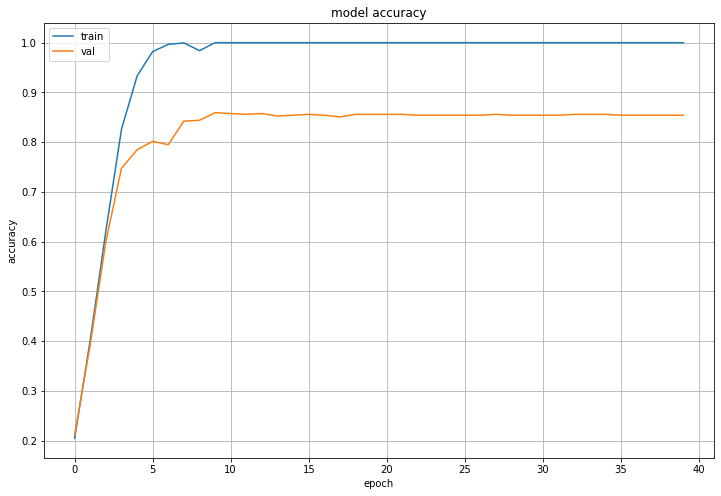

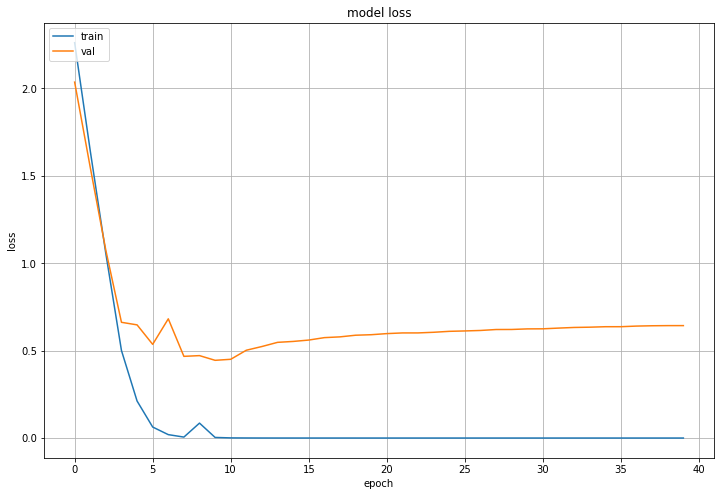

In [92]:
accuracy_plot(history)
loss_plot(history)

# Model 2:

In [93]:
#Define Model
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))#Compile
print(model2.summary())#Train and Test The Model

model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 146, 18, 32)       320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 144, 16, 64)       18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 72, 8, 64)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 72, 8, 64)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               4718720   
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)             

In [94]:
%%time
from keras.callbacks import ModelCheckpoint,  EarlyStopping
esp =  EarlyStopping(monitor='val_loss', patience=30)
checkpoint = ModelCheckpoint(filepath='Model_2.weights.best.27_10.hdf5', save_best_only=True, verbose=0)

# Training the model for 40 epochs
history = model2.fit(x_train, y_train, batch_size=32, epochs=200, 
                    validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint,esp])

Wall time: 52min 41s


In [95]:
# Loading the model that performed the best on the validation set
model2.load_weights('Model_2.weights.best.27_10.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model2.evaluate(x_test, y_test, batch_size=32, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

590/590 [==============================] - 1s 2ms/step
Accuracy on test data: 92.71%


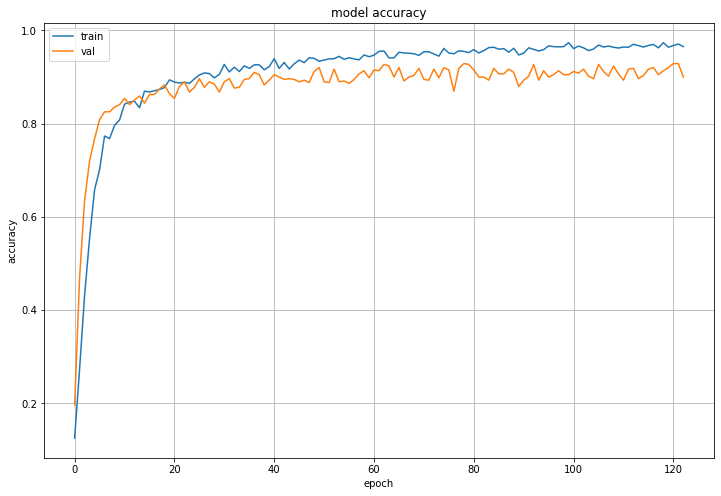

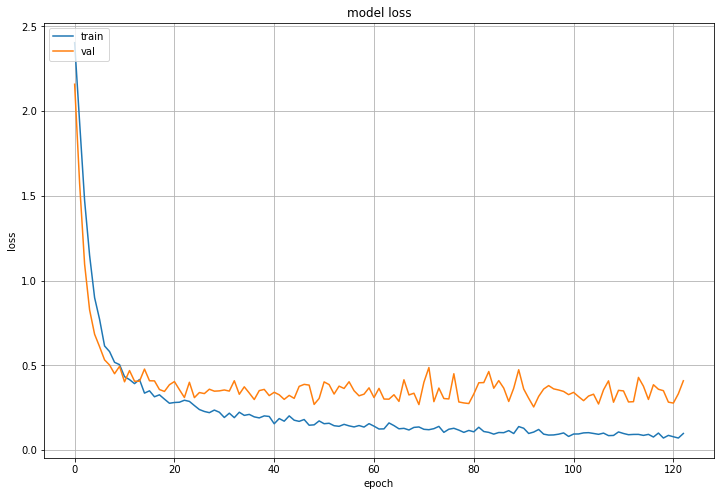

In [96]:
accuracy_plot(history)
loss_plot(history)

# Model 3:

In [97]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD


model3 = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation='softmax'))

print(model3.summary())
model3.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
#Train and Test The Model


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 146, 18, 32)       320       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 144, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 72, 8, 32)         0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 72, 8, 32)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 70, 6, 64)         18496     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 68, 4, 64)         36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 34, 2, 64)       

In [98]:
%%time
from keras.callbacks import ModelCheckpoint,  EarlyStopping
esp =  EarlyStopping(monitor='val_loss', patience=30)
checkpoint = ModelCheckpoint(filepath='Model_3.weights.best.27_10.hdf5', save_best_only=True, verbose=0)

# Training the model for 40 epochs
history = model3.fit(x_train, y_train, batch_size=32, epochs=200, 
                    validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint,esp])

Wall time: 1h 6min 17s


In [99]:
# Loading the model that performed the best on the validation set
model3.load_weights('Model_3.weights.best.27_10.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model3.evaluate(x_test, y_test, batch_size=32, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

590/590 [==============================] - 1s 1ms/step
Accuracy on test data: 95.76%


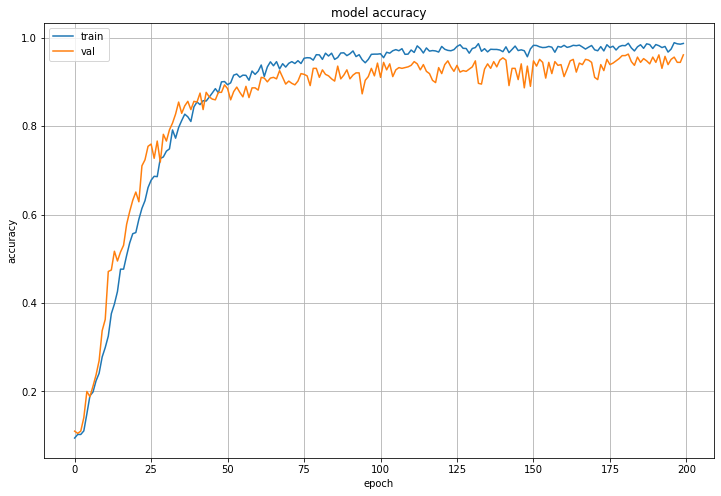

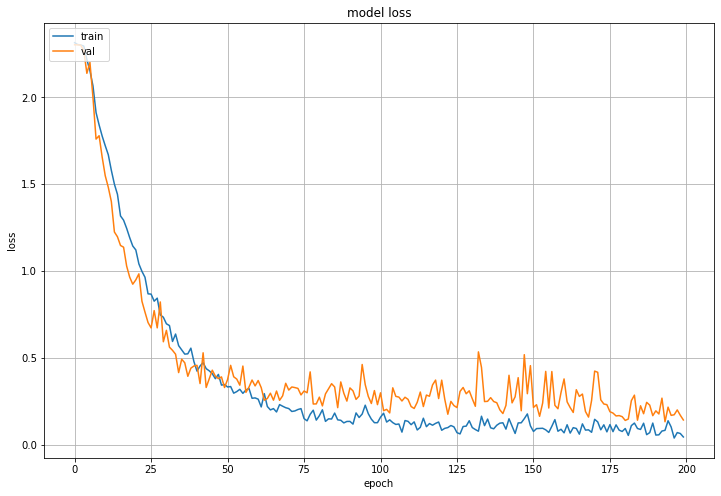

In [100]:
accuracy_plot(history)
loss_plot(history)